In [1]:
# Cell 1: Setup, Configuration, and Loading Hyperparameters

import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib
import matplotlib.pyplot as plt
import json

# --- Configuration (Must match the setup of the data being used for evaluation) ---
# !!! IMPORTANT: UPDATE THIS PATH IF IT'S DIFFERENT !!!
model_ready_data_dir = r'D:\.Study\projects\EnergyForecasting\data\model_ready' # Path to your OLDER/SMALLER dataset's processed files
scaler_path = os.path.join(model_ready_data_dir, 'feature_scaler_multiyear.joblib') # Scaler for your OLDER/SMALLER dataset

INPUT_SEQ_LEN = 24
PREDICTION_HORIZON = 1
# This ANALYSIS_DROPOUT_RATE should ideally match what the ..._multiyear.pth model was defined with.
# If it was part of Optuna's search for that model, it should be in its best_params.json.
# If not, use the value it was trained with or a sensible default for evaluation (0.0 or training value).
ANALYSIS_DROPOUT_RATE = 0.2 # Assuming 0.2 was used for the multiyear model, or it will be overridden by best_params

# PJM Zones
zone_identifiers = ['DOM', 'PN', 'PEPCO', 'AECO', 'PE']
num_nodes = len(zone_identifiers)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

target_column_template = '{ZONE}_Load'

# --- Load Hyperparameters ---
# These hyperparameters should ideally be the ones used to define the ARCHITECTURE
# of the ..._multiyear.pth model. If you have a specific best_params.json for the multiyear model,
# point to that. If not, we'll use the ones from the study that produced the model name.
# The study name should match the prefix of your model file.
analysis_study_name = "stgnn_multiyear_study_v1" # This prefix matches your model filename
# Assuming best_params for the multiyear model might be in a similarly named JSON.
# If the multiyear model had its own Optuna study, use that study's JSON file.
# For now, we'll use the one associated with the 'analysis_study_name'.
best_params_path = os.path.join(model_ready_data_dir, f'{analysis_study_name}_best_params.json')
# ^^^ This path might need to point to a different directory if multiyear params are elsewhere.

try:
    with open(best_params_path, 'r') as f:
        best_params_for_analysis = json.load(f)
    print(f"Loaded hyperparameters for model architecture from {best_params_path}:")
    print(json.dumps(best_params_for_analysis, indent=4))
except FileNotFoundError:
    print(f"WARNING: Hyperparameters file not found at {best_params_path}.")
    print("Ensure this file contains the architecture parameters for the model being loaded.")
    print("Using fallback default architecture parameters, which might mismatch the saved model.")
    # Fallback based on your successful Trial 0 if specific JSON for multiyear model is missing
    best_params_for_analysis = {
        "gnn_hidden_channels": 128, "gnn_out_channels": 64,
        "lstm_hidden_dim": 64, "lstm_num_layers": 1, "batch_size": 32
        # "dropout_rate": 0.2 # If dropout was tuned and saved
    }
    ANALYSIS_DROPOUT_RATE = best_params_for_analysis.get("dropout_rate", 0.2)


# Assign params from loaded JSON (use .get for safety with defaults)
analysis_batch_size = best_params_for_analysis.get("batch_size", 32)
analysis_gnn_h = best_params_for_analysis.get("gnn_hidden_channels", 128)
analysis_gnn_o = best_params_for_analysis.get("gnn_out_channels", 64)
analysis_lstm_h = best_params_for_analysis.get("lstm_hidden_dim", 64)
analysis_lstm_l = best_params_for_analysis.get("lstm_num_layers", 1)
# Override ANALYSIS_DROPOUT_RATE if it was tuned and present in best_params
if "dropout_rate" in best_params_for_analysis:
    ANALYSIS_DROPOUT_RATE = best_params_for_analysis["dropout_rate"]


# Path to the specific trained model file you want to analyze
model_to_analyze_filename = f'{analysis_study_name}_model_final_trained_multiyear.pth'
model_to_analyze_path = os.path.join(model_ready_data_dir, model_to_analyze_filename)
# ^^^ If model_ready_data_dir for multiyear files is different, adjust path here.
# For example: model_to_analyze_path = os.path.join(model_ready_data_dir_MULTIYEAR, model_to_analyze_filename)

print(f"Attempting to load model from: {model_to_analyze_path}")

# Global variable to hold training column names for model's _prepare_feature_indices
temp_train_cols_for_model_init = []

Using device: cuda
Loaded hyperparameters for model architecture from D:\.Study\projects\EnergyForecasting\data\model_ready\stgnn_multiyear_study_v1_best_params.json:
{
    "learning_rate": 0.000613049645560782,
    "batch_size": 32,
    "gnn_hidden_channels": 128,
    "gnn_out_channels": 48,
    "lstm_hidden_dim": 128,
    "lstm_num_layers": 2
}
Attempting to load model from: D:\.Study\projects\EnergyForecasting\data\model_ready\stgnn_multiyear_study_v1_model_final_trained_multiyear.pth


In [2]:
# Cell 2: Model Class Definitions and Graph Structure

from torch_geometric.nn import GCNConv

# --- Model Classes (Must be identical to those used for training the model being loaded) ---
class GNN_Component(nn.Module):
    def __init__(self, in_channels, gnn_hidden_channels, gnn_out_channels, dropout_rate):
        super().__init__()
        self.conv1 = GCNConv(in_channels, gnn_hidden_channels)
        self.lin = nn.Linear(gnn_hidden_channels, gnn_out_channels)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
    def forward(self, x_node_features_at_t, current_edge_index):
        x = self.conv1(x_node_features_at_t, current_edge_index)
        x = self.relu(x); x = self.dropout(x); x = self.lin(x)
        return x

class Temporal_Component(nn.Module):
    def __init__(self, input_dim_per_node, lstm_hidden_dim, num_lstm_layers, dropout_rate):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim_per_node, hidden_size=lstm_hidden_dim,
                              num_layers=num_lstm_layers, batch_first=True,
                              dropout=dropout_rate if num_lstm_layers > 1 else 0)
    def forward(self, gnn_processed_sequence_for_all_nodes):
        lstm_out, _ = self.lstm(gnn_processed_sequence_for_all_nodes)
        return lstm_out[:, -1, :]

class STGNN_Model(nn.Module):
    def __init__(self, model_num_all_features_in_df, model_num_nodes, model_num_features_per_node_slice_for_gnn,
                 gnn_hidden_channels, gnn_out_channels, lstm_hidden_dim, num_lstm_layers,
                 model_all_zones_list, model_common_time_features_list,
                 dropout_rate, model_pred_horizon):
        super().__init__()
        self.num_nodes = model_num_nodes
        self.gnn_out_channels = gnn_out_channels
        self.pred_horizon = model_pred_horizon
        self.all_zones = model_all_zones_list
        self.common_time_feature_names = model_common_time_features_list
        self.num_features_per_node_slice_for_gnn = model_num_features_per_node_slice_for_gnn
        self.col_names_from_df = None; self.zone_feature_indices = {}; self.common_feature_indices = []

        self.gnn_module = GNN_Component(self.num_features_per_node_slice_for_gnn, gnn_hidden_channels, gnn_out_channels, dropout_rate)
        self.temporal_module = Temporal_Component(gnn_out_channels, lstm_hidden_dim, num_lstm_layers, dropout_rate)
        self.fc_out = nn.Linear(lstm_hidden_dim, self.pred_horizon)

    def _prepare_feature_indices(self, all_df_columns_list_arg):
        if self.col_names_from_df is None:
            self.col_names_from_df = list(all_df_columns_list_arg)
            self.common_feature_indices = [
                self.col_names_from_df.index(cf_name) for cf_name in self.common_time_feature_names
                if cf_name in self.col_names_from_df ]
            for zone_name in self.all_zones:
                self.zone_feature_indices[zone_name] = [
                    idx for idx, col_name_in_df in enumerate(self.col_names_from_df)
                    if col_name_in_df.startswith(zone_name + "_") ]
    def _extract_node_features_at_t(self, x_batch_slice_t):
        batch_node_feature_tensors = []
        for zone_name in self.all_zones:
            current_node_specific_indices = self.zone_feature_indices.get(zone_name, [])
            combined_indices_for_node = current_node_specific_indices + self.common_feature_indices
            seen = set(); unique_ordered_indices_for_node = [x for x in combined_indices_for_node if not (x in seen or seen.add(x))]
            node_features_for_batch = x_batch_slice_t[:, unique_ordered_indices_for_node]
            if node_features_for_batch.shape[1] != self.num_features_per_node_slice_for_gnn:
                raise ValueError(f"Shape mismatch GNN input {zone_name}. Exp {self.num_features_per_node_slice_for_gnn}, Got {node_features_for_batch.shape[1]}")
            batch_node_feature_tensors.append(node_features_for_batch.unsqueeze(1))
        return torch.cat(batch_node_feature_tensors, dim=1)

    def forward(self, x_batch_sequences, current_edge_index):
        global temp_train_cols_for_model_init
        if self.col_names_from_df is None:
            if not temp_train_cols_for_model_init:
                 raise RuntimeError("Global 'temp_train_cols_for_model_init' is empty.")
            self._prepare_feature_indices(temp_train_cols_for_model_init)

        batch_size, seq_len = x_batch_sequences.shape[0], x_batch_sequences.shape[1]
        gnn_outputs_over_time_for_batch = []
        for t_step in range(seq_len):
            x_slice_t_batch = x_batch_sequences[:, t_step, :]
            gnn_input_at_t_for_batch = self._extract_node_features_at_t(x_slice_t_batch)
            current_t_gnn_outs_batch = []
            for b_idx in range(batch_size):
                gnn_input_single_graph = gnn_input_at_t_for_batch[b_idx]
                gnn_out_slice = self.gnn_module(gnn_input_single_graph, current_edge_index)
                current_t_gnn_outs_batch.append(gnn_out_slice.unsqueeze(0))
            gnn_out_at_t_batch = torch.cat(current_t_gnn_outs_batch, dim=0)
            gnn_outputs_over_time_for_batch.append(gnn_out_at_t_batch.unsqueeze(1))

        final_gnn_sequences_batch = torch.cat(gnn_outputs_over_time_for_batch, dim=1)
        lstm_input = final_gnn_sequences_batch.permute(0, 2, 1, 3)
        lstm_input = lstm_input.reshape(batch_size * self.num_nodes, seq_len, self.gnn_out_channels)
        lstm_out_last_step = self.temporal_module(lstm_input)
        predictions_flat = self.fc_out(lstm_out_last_step)
        predictions = predictions_flat.view(batch_size, self.num_nodes, self.pred_horizon)
        if self.pred_horizon == 1:  predictions = predictions.squeeze(-1)
        return predictions

# --- Define Graph Structure (Must match training of the loaded model) ---
edge_list_tuples_analysis = [(0, 2), (0, 4), (1, 4), (4, 2), (4, 3), (2, 3)]
undirected_edge_list_analysis = []
for u, v in edge_list_tuples_analysis:
    undirected_edge_list_analysis.append((u, v)); undirected_edge_list_analysis.append((v, u))
for i in range(num_nodes): undirected_edge_list_analysis.append((i, i))
unique_edges_analysis = sorted(list(set(undirected_edge_list_analysis)))
edge_index_analysis = torch.tensor(unique_edges_analysis, dtype=torch.long).t().contiguous().to(device)

print("Model classes and graph structure redefined for analysis notebook.")

Model classes and graph structure redefined for analysis notebook.


In [3]:
# Cell 3: Load Data, Instantiate Model, and Load Weights

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- Load data (OLDER/SMALLER dataset files for this analysis) ---
global temp_train_cols_for_model_init # Ensure global scope for use in STGNN_Model

try:
    train_cols_df_for_init = pd.read_csv(os.path.join(model_ready_data_dir, 'train_scaled_multiyear.csv'), index_col=0, parse_dates=True, nrows=1)
    temp_train_cols_for_model_init = train_cols_df_for_init.columns.tolist()
    del train_cols_df_for_init

    val_scaled_df_analysis = pd.read_csv(os.path.join(model_ready_data_dir, 'val_scaled_multiyear.csv'), index_col=0, parse_dates=True)
    print(f"Loaded val_scaled.csv (shape: {val_scaled_df_analysis.shape}) for analysis.")
    print(f"Loaded column names from train_scaled.csv (count: {len(temp_train_cols_for_model_init)}).")
except FileNotFoundError:
    print(f"ERROR: val_scaled.csv or train_scaled.csv not found in {model_ready_data_dir}.")
    raise

# --- Calculate feature counts based on the OLDER/SMALLER train_scaled.csv columns ---
# These counts MUST match what the loaded ..._multiyear.pth model expects for its input layer.
# If they don't, model loading or forward pass will fail.
common_time_features_gnn_analysis = [col for col in temp_train_cols_for_model_init if not any(zone in col for zone in zone_identifiers)]
if not zone_identifiers: raise ValueError("zone_identifiers list is empty.")
if not temp_train_cols_for_model_init : raise ValueError("temp_train_cols_for_model_init is empty. train_scaled.csv columns not loaded.")

first_zone_prefix = zone_identifiers[0] + "_"
first_zone_specific_features_analysis = [col for col in temp_train_cols_for_model_init if col.startswith(first_zone_prefix)]
if not first_zone_specific_features_analysis and any(first_zone_prefix in col for col in temp_train_cols_for_model_init):
     print(f"Warning: No specific features found starting with '{first_zone_prefix}' for zone {zone_identifiers[0]}. Check logic if this is unexpected.")


num_features_per_node_slice_analysis = len(first_zone_specific_features_analysis) + len(common_time_features_gnn_analysis)
num_all_features_analysis = len(temp_train_cols_for_model_init)

print(f"\nFeature counts for model instantiation (based on OLDER train_scaled.csv columns):")
print(f"  Number of all features (total columns): {num_all_features_analysis}")
print(f"  Number of common time features: {len(common_time_features_gnn_analysis)}")
print(f"  Number of specific features for first zone '{zone_identifiers[0]}': {len(first_zone_specific_features_analysis)}")
print(f"  Calculated num_features_per_node_slice_for_gnn: {num_features_per_node_slice_analysis}")
print("  (These counts must match the architecture of the loaded ..._multiyear.pth model)")


# --- Instantiate the Model ---
print("\nInstantiating STGNN_Model for evaluation...")
model_to_evaluate = STGNN_Model(
    model_num_all_features_in_df=num_all_features_analysis,
    model_num_nodes=num_nodes,
    model_num_features_per_node_slice_for_gnn=num_features_per_node_slice_analysis,
    gnn_hidden_channels=analysis_gnn_h, gnn_out_channels=analysis_gnn_o,
    lstm_hidden_dim=analysis_lstm_h, num_lstm_layers=analysis_lstm_l,
    model_all_zones_list=zone_identifiers,
    model_common_time_features_list=common_time_features_gnn_analysis,
    dropout_rate=ANALYSIS_DROPOUT_RATE, model_pred_horizon=PREDICTION_HORIZON
).to(device)

# --- Load Saved Model Weights (..._multiyear.pth) ---
try:
    if not os.path.exists(model_to_analyze_path):
        raise FileNotFoundError(f"Model file not found: {model_to_analyze_path}")
    model_to_evaluate.load_state_dict(torch.load(model_to_analyze_path, map_location=device))
    model_to_evaluate.eval() # Set to evaluation mode
    print(f"Model weights from '{model_to_analyze_filename}' loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: Saved model file '{model_to_analyze_filename}' not found at {model_to_analyze_path}.")
    raise
except RuntimeError as e:
    print(f"ERROR loading model state_dict from '{model_to_analyze_filename}': {e}")
    print("This often means a mismatch between the model architecture defined here (based on OLDER data features/hyperparams from JSON) and the saved model's actual architecture (from MULTIYEAR training).")
    print("Ensure feature counts and layer dimensions match EXACTLY.")
    raise
except Exception as e:
    print(f"An unexpected error occurred loading model weights: {e}")
    raise

# --- Load Scaler (from OLDER/SMALLER dataset) ---
try:
    scaler_analysis = joblib.load(scaler_path)
    print(f"Scaler (from OLDER dataset) loaded successfully from {scaler_path}")
except FileNotFoundError:
    print(f"ERROR: Scaler file not found at {scaler_path}.")
    raise

Loaded val_scaled.csv (shape: (4456, 94)) for analysis.
Loaded column names from train_scaled.csv (count: 94).

Feature counts for model instantiation (based on OLDER train_scaled.csv columns):
  Number of all features (total columns): 94
  Number of common time features: 14
  Number of specific features for first zone 'DOM': 16
  Calculated num_features_per_node_slice_for_gnn: 30
  (These counts must match the architecture of the loaded ..._multiyear.pth model)

Instantiating STGNN_Model for evaluation...
Model weights from 'stgnn_multiyear_study_v1_model_final_trained_multiyear.pth' loaded successfully.
Scaler (from OLDER dataset) loaded successfully from D:\.Study\projects\EnergyForecasting\data\model_ready\feature_scaler_multiyear.joblib


In [4]:
# Cell 4: Prepare Validation Data and Get Predictions

def create_sequences_analysis(input_data_df, input_seq_len, pred_horizon, target_cols_template, all_zones):
    X_list, y_list = [], []
    if len(input_data_df) < input_seq_len + pred_horizon:
        print(f"Warning: Not enough data in input_data_df (len: {len(input_data_df)}) to create sequences.")
        return np.array(X_list), np.array(y_list)
    for i in range(len(input_data_df) - input_seq_len - pred_horizon + 1):
        X_list.append(input_data_df.iloc[i : i + input_seq_len].values)
        targets_current_step = []
        for zone in all_zones:
            target_col_name = target_cols_template.replace('{ZONE}', zone)
            target_val = input_data_df[target_col_name].iloc[i + input_seq_len + pred_horizon - 1]
            targets_current_step.append(target_val)
        y_list.append(targets_current_step)
    return np.array(X_list), np.array(y_list)

print(f"\nCreating sequences from OLDER validation data (shape: {val_scaled_df_analysis.shape})...")
X_val_analysis, y_val_analysis_true_scaled = create_sequences_analysis(
    val_scaled_df_analysis, INPUT_SEQ_LEN, PREDICTION_HORIZON, target_column_template, zone_identifiers
)

if X_val_analysis.size == 0:
    raise ValueError("No sequences created from validation data. Cannot proceed.")

X_val_tensor_analysis = torch.from_numpy(X_val_analysis).float()
print(f"  X_val_tensor_analysis shape: {X_val_tensor_analysis.shape}")
print(f"  y_val_analysis_true_scaled shape: {y_val_analysis_true_scaled.shape}")

eval_batch_size = analysis_batch_size
val_dataset_analysis = TimeSeriesDataset(X_val_tensor_analysis, torch.from_numpy(y_val_analysis_true_scaled).float())
val_loader_analysis = DataLoader(val_dataset_analysis, batch_size=eval_batch_size, shuffle=False, drop_last=False)
print(f"Validation DataLoader created with batch size: {eval_batch_size}")

all_val_preds_scaled_list = []
model_to_evaluate.eval()
print("Generating predictions on OLDER validation set...")
with torch.no_grad():
    for x_batch_val, _ in val_loader_analysis:
        x_batch_val = x_batch_val.to(device)
        predictions_val_batch_scaled = model_to_evaluate(x_batch_val, edge_index_analysis)
        all_val_preds_scaled_list.append(predictions_val_batch_scaled.cpu().numpy())

if not all_val_preds_scaled_list:
    raise ValueError("No predictions generated.")
all_val_preds_scaled_np = np.concatenate(all_val_preds_scaled_list, axis=0)
print(f"Shape of concatenated predictions (scaled): {all_val_preds_scaled_np.shape}")

if len(all_val_preds_scaled_np) != len(y_val_analysis_true_scaled):
    print(f"WARNING: Prediction count ({len(all_val_preds_scaled_np)}) != Target count ({len(y_val_analysis_true_scaled)}). Truncating.")
    min_len = min(len(all_val_preds_scaled_np), len(y_val_analysis_true_scaled))
    all_val_preds_scaled_np = all_val_preds_scaled_np[:min_len]
    y_val_analysis_true_scaled = y_val_analysis_true_scaled[:min_len]
print("Predictions generated.")


Creating sequences from OLDER validation data (shape: (4456, 94))...
  X_val_tensor_analysis shape: torch.Size([4432, 24, 94])
  y_val_analysis_true_scaled shape: (4432, 5)
Validation DataLoader created with batch size: 32
Generating predictions on OLDER validation set...
Shape of concatenated predictions (scaled): (4432, 5)
Predictions generated.



Preparing DataFrames for inverse transform using OLDER scaler structure (94 columns)...
Performing inverse transform using OLDER scaler...

Sample of Predictions (Original Scale - using OLDER scaler):
                               DOM_Load      PN_Load   PEPCO_Load  \
2024-05-24 18:00:00+00:00  16552.066814  2204.253353  3535.507363   
2024-05-24 19:00:00+00:00  16832.685102  2201.955545  3642.798212   
2024-05-24 20:00:00+00:00  17038.653387  2190.327313  3706.473969   
2024-05-24 21:00:00+00:00  17098.180841  2189.829102  3721.794962   
2024-05-24 22:00:00+00:00  17036.924250  2177.562406  3705.127043   

                             AECO_Load      PE_Load  
2024-05-24 18:00:00+00:00  1169.964618  5583.481156  
2024-05-24 19:00:00+00:00  1258.231366  5729.596310  
2024-05-24 20:00:00+00:00  1356.747453  5802.551504  
2024-05-24 21:00:00+00:00  1462.723077  5835.423035  
2024-05-24 22:00:00+00:00  1533.641347  5799.582586  

Generating plots...


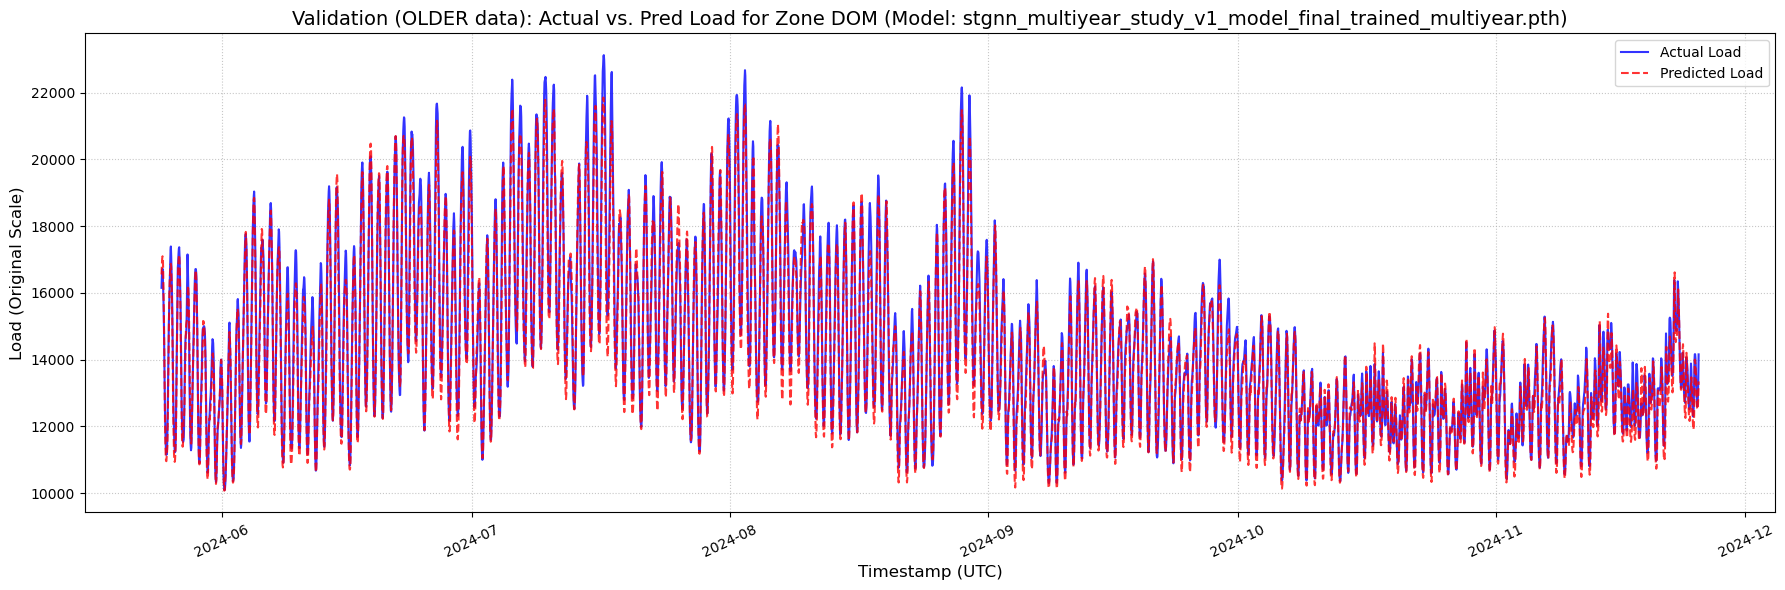

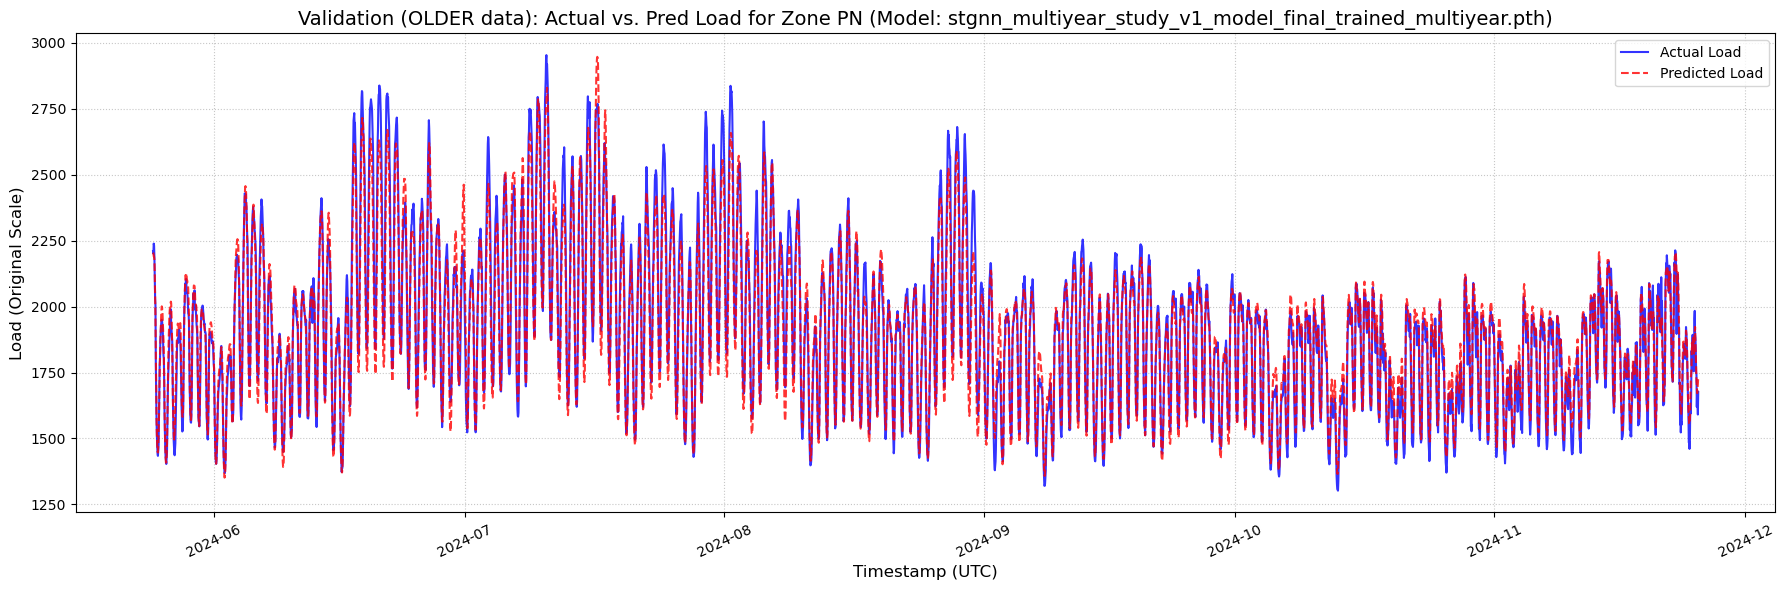

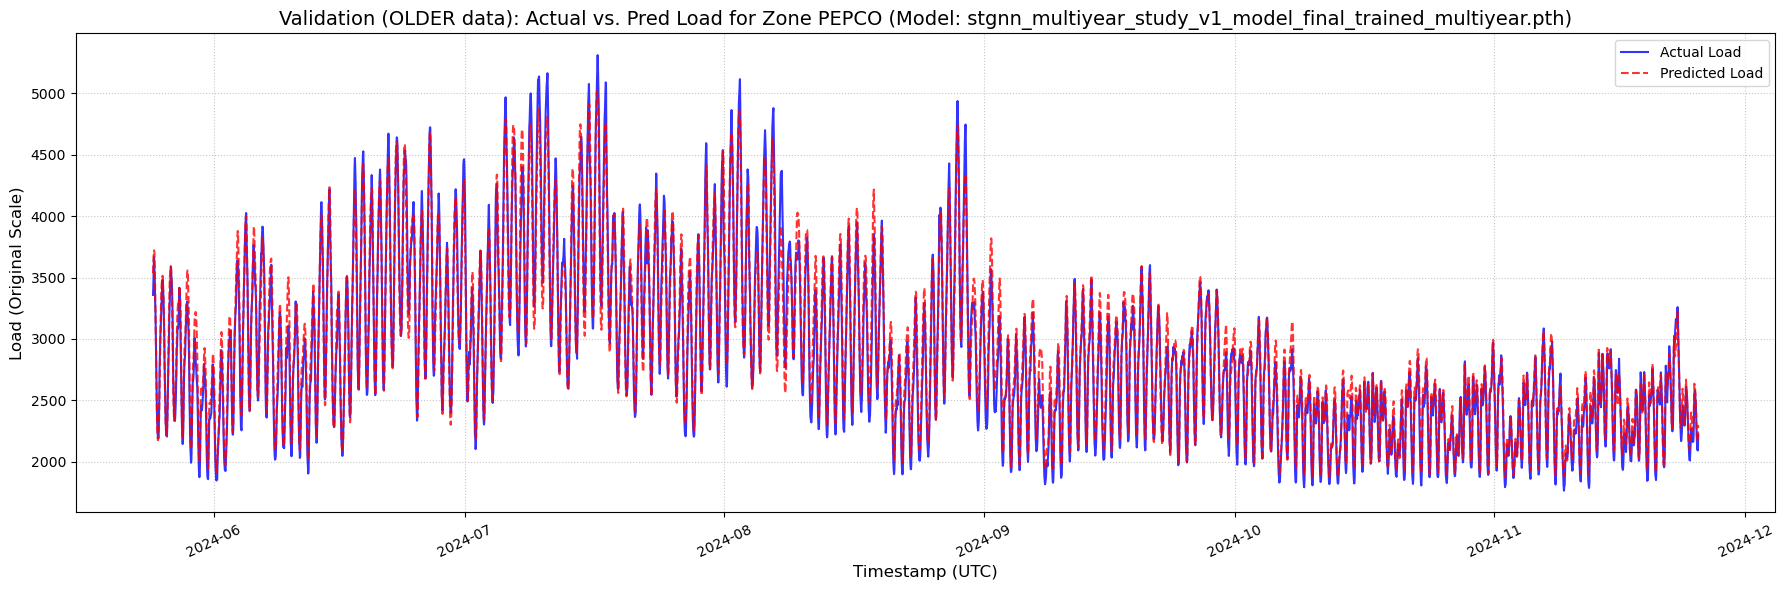

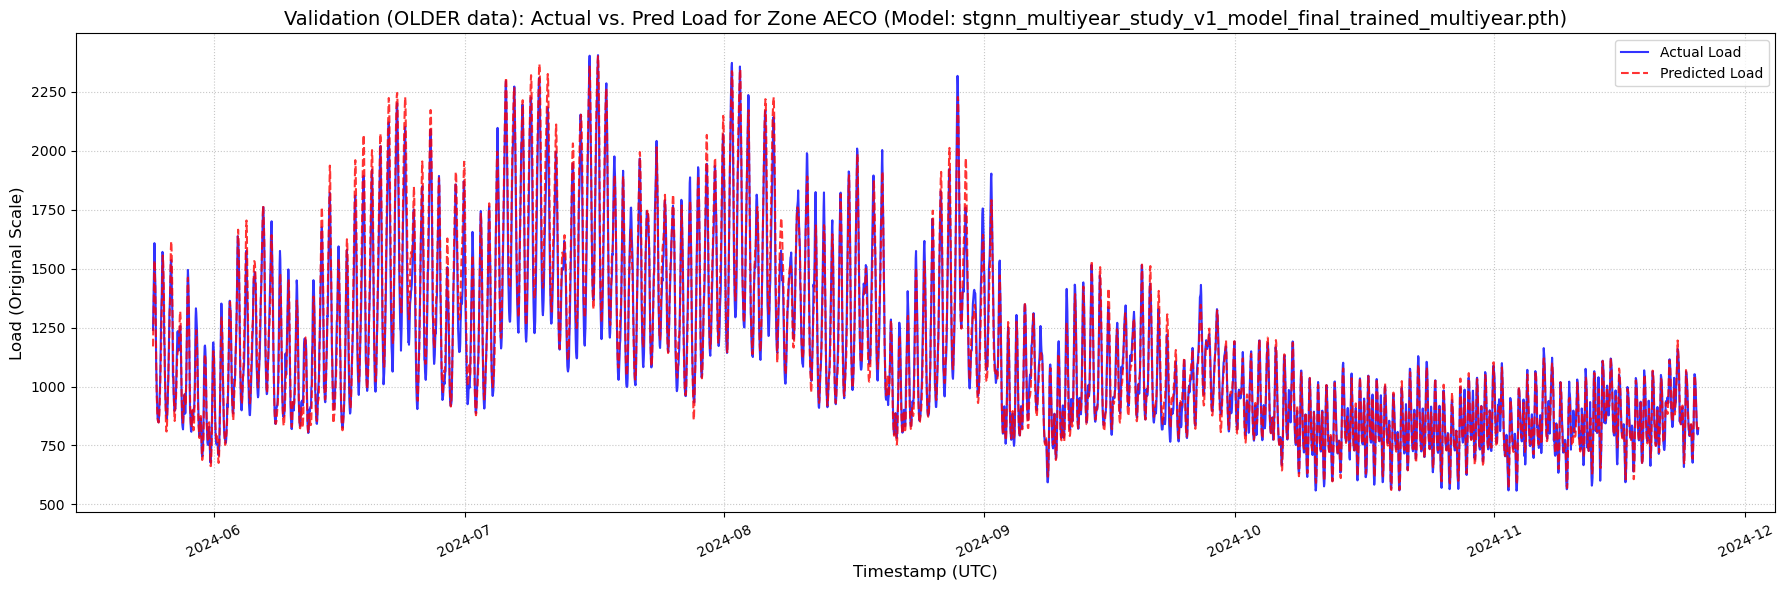

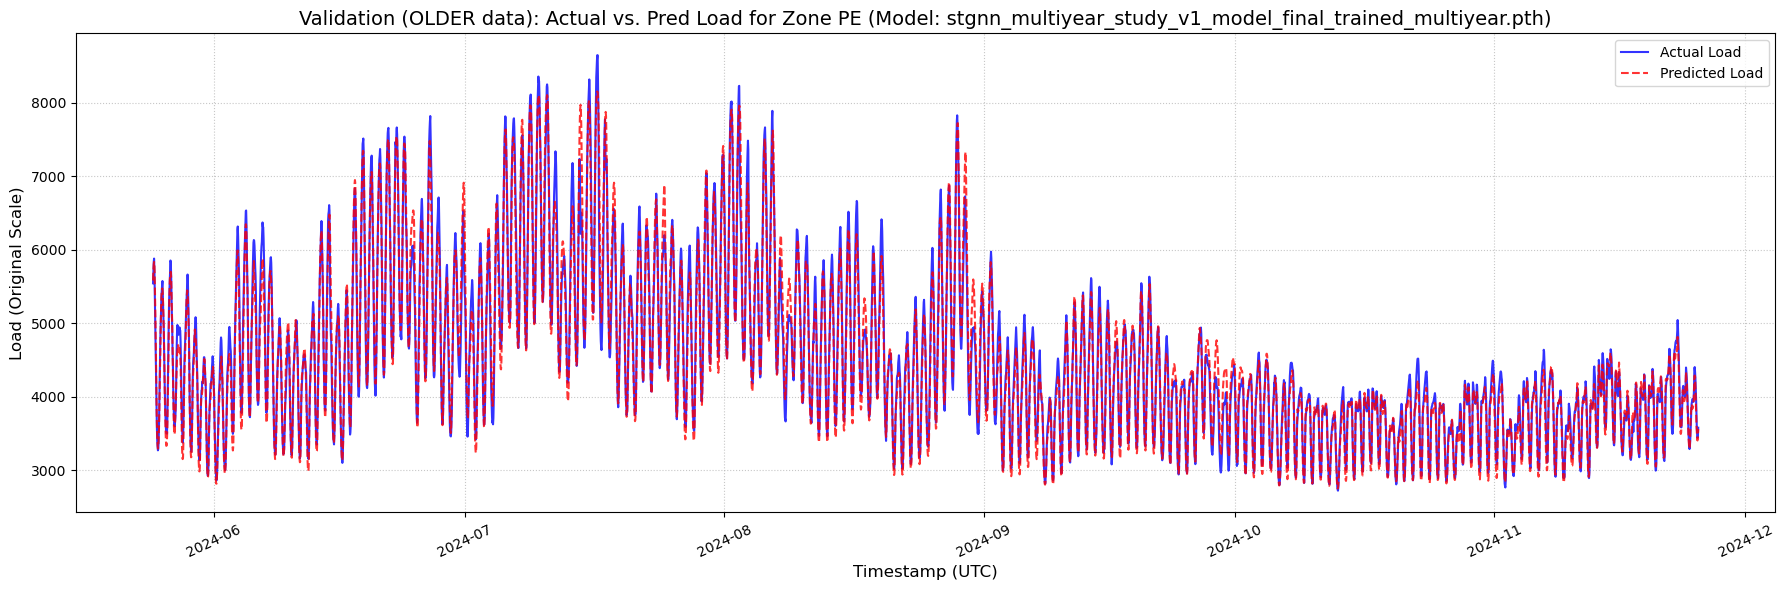


--- Metrics on Original Scale (Validation Set - using OLDER scaler) ---

Metrics for Zone DOM: MSE: 149540.86, RMSE: 386.71, MAE: 291.87, MAPE: 1.96%

Metrics for Zone PN: MSE: 4000.47, RMSE: 63.25, MAE: 46.97, MAPE: 2.38%

Metrics for Zone PEPCO: MSE: 14781.41, RMSE: 121.58, MAE: 92.00, MAPE: 3.17%

Metrics for Zone AECO: MSE: 3083.38, RMSE: 55.53, MAE: 39.67, MAPE: 3.27%

Metrics for Zone PE: MSE: 35359.49, RMSE: 188.04, MAE: 132.50, MAPE: 2.81%

Overall Metrics (All Zones): MSE: 41353.12, RMSE: 203.35, MAE: 120.60, MAPE: 2.72%

Error analysis complete.


In [5]:
# Cell 5: Inverse Transform and Calculate Metrics & Plots

from sklearn.metrics import mean_squared_error, mean_absolute_error

target_load_cols_analysis = [target_column_template.replace('{ZONE}', zone) for zone in zone_identifiers]
num_val_output_samples = len(y_val_analysis_true_scaled)
if num_val_output_samples == 0:
    raise ValueError("No validation target samples for analysis.")

val_target_timestamps_analysis = val_scaled_df_analysis.index[INPUT_SEQ_LEN + PREDICTION_HORIZON - 1 : INPUT_SEQ_LEN + PREDICTION_HORIZON - 1 + num_val_output_samples]
if len(val_target_timestamps_analysis) != num_val_output_samples:
    raise ValueError(f"Timestamp length mismatch. Expected {num_val_output_samples}, got {len(val_target_timestamps_analysis)}.")

preds_scaled_df = pd.DataFrame(all_val_preds_scaled_np, columns=target_load_cols_analysis, index=val_target_timestamps_analysis)
true_scaled_df = pd.DataFrame(y_val_analysis_true_scaled, columns=target_load_cols_analysis, index=val_target_timestamps_analysis)

# Use global `temp_train_cols_for_model_init` (from OLDER train_scaled.csv) for scaler's expected structure
df_for_inverse_preds = pd.DataFrame(columns=temp_train_cols_for_model_init, index=val_target_timestamps_analysis, dtype=float)
df_for_inverse_true = pd.DataFrame(columns=temp_train_cols_for_model_init, index=val_target_timestamps_analysis, dtype=float)
print(f"\nPreparing DataFrames for inverse transform using OLDER scaler structure ({len(temp_train_cols_for_model_init)} columns)...")

for col in temp_train_cols_for_model_init:
    if col in target_load_cols_analysis:
        df_for_inverse_preds[col] = preds_scaled_df[col].values
        df_for_inverse_true[col] = true_scaled_df[col].values
    elif col in val_scaled_df_analysis.columns: # val_scaled_df_analysis is the OLDER validation data
        if val_target_timestamps_analysis.isin(val_scaled_df_analysis.index).all():
             # Ensure indices align by using .loc and .values
            df_for_inverse_preds[col] = val_scaled_df_analysis.loc[val_target_timestamps_analysis, col].values
            df_for_inverse_true[col] = val_scaled_df_analysis.loc[val_target_timestamps_analysis, col].values
        else: # Should not happen if val_target_timestamps_analysis is derived correctly
            print(f"Warning: Timestamp mismatch for column {col}. Filling with 0.")
            df_for_inverse_preds[col] = 0.0
            df_for_inverse_true[col] = 0.0
    else:
        df_for_inverse_preds[col] = 0.0
        df_for_inverse_true[col] = 0.0

print("Performing inverse transform using OLDER scaler...")
val_preds_original_scale_array = scaler_analysis.inverse_transform(df_for_inverse_preds)
val_true_original_scale_array = scaler_analysis.inverse_transform(df_for_inverse_true)

val_preds_df_orig = pd.DataFrame(val_preds_original_scale_array, columns=temp_train_cols_for_model_init, index=val_target_timestamps_analysis)[target_load_cols_analysis]
val_true_df_orig = pd.DataFrame(val_true_original_scale_array, columns=temp_train_cols_for_model_init, index=val_target_timestamps_analysis)[target_load_cols_analysis]

print("\nSample of Predictions (Original Scale - using OLDER scaler):")
print(val_preds_df_orig.head())

print("\nGenerating plots...")
for zone_name_analysis in zone_identifiers:
    target_col_plot = f"{zone_name_analysis}_Load"
    plt.figure(figsize=(18, 6))
    plt.plot(val_true_df_orig.index, val_true_df_orig[target_col_plot], label='Actual Load', color='blue', alpha=0.8, linewidth=1.5)
    plt.plot(val_preds_df_orig.index, val_preds_df_orig[target_col_plot], label='Predicted Load', color='red', linestyle='--', alpha=0.8, linewidth=1.5)
    plt.title(f'Validation (OLDER data): Actual vs. Pred Load for Zone {zone_name_analysis} (Model: {model_to_analyze_filename})', fontsize=14)
    plt.xlabel('Timestamp (UTC)', fontsize=12); plt.ylabel('Load (Original Scale)', fontsize=12)
    plt.legend(fontsize=10); plt.grid(True, linestyle=':', alpha=0.7); plt.xticks(rotation=25)
    plt.tight_layout(); plt.show()

print("\n--- Metrics on Original Scale (Validation Set - using OLDER scaler) ---")
overall_actuals_metrics, overall_predictions_metrics = [], []
for zone_name_metrics in zone_identifiers:
    target_col_metrics = f"{zone_name_metrics}_Load"
    actuals_zone = val_true_df_orig[target_col_metrics]; preds_zone = val_preds_df_orig[target_col_metrics]
    overall_actuals_metrics.extend(actuals_zone.tolist()); overall_predictions_metrics.extend(preds_zone.tolist())
    mse_zone = mean_squared_error(actuals_zone, preds_zone); rmse_zone = np.sqrt(mse_zone)
    mae_zone = mean_absolute_error(actuals_zone, preds_zone)
    actuals_for_mape_zone = actuals_zone.replace(0, 1e-9)
    mape_zone = np.mean(np.abs((actuals_zone - preds_zone) / actuals_for_mape_zone)) * 100
    print(f"\nMetrics for Zone {zone_name_metrics}: MSE: {mse_zone:.2f}, RMSE: {rmse_zone:.2f}, MAE: {mae_zone:.2f}, MAPE: {mape_zone:.2f}%")

if overall_actuals_metrics:
    overall_mse = mean_squared_error(overall_actuals_metrics, overall_predictions_metrics)
    overall_rmse = np.sqrt(overall_mse); overall_mae = mean_absolute_error(overall_actuals_metrics, overall_predictions_metrics)
    s_overall_actuals = pd.Series(overall_actuals_metrics).replace(0, 1e-9)
    s_overall_preds = pd.Series(overall_predictions_metrics)
    overall_mape = np.mean(np.abs((s_overall_actuals - s_overall_preds) / s_overall_actuals)) * 100
    print(f"\nOverall Metrics (All Zones): MSE: {overall_mse:.2f}, RMSE: {overall_rmse:.2f}, MAE: {overall_mae:.2f}, MAPE: {overall_mape:.2f}%")
else:
    print("No data for overall metrics.")
print("\nError analysis complete.")